In [2]:
# Setup

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

Cleaning Data
Filling 33297 empty senders
Removing receiver (not useful for classification)
Dropping 0 rows with both subject and body missing
Filling 503 empty subjects
Filling 1 empty bodies
Filling 32626 empty URLs


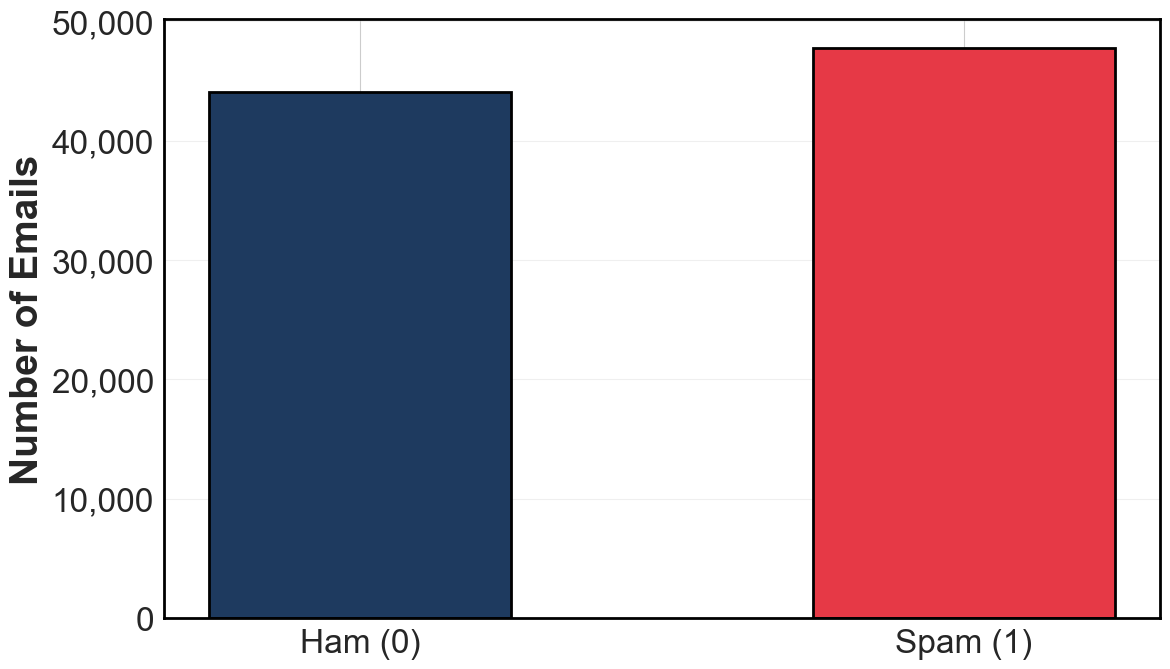

In [12]:
CEAS_08 = pd.read_csv("datasets/CEAS_08.csv", encoding="utf-8", on_bad_lines="skip")
ENRON = pd.read_csv("datasets/Enron.csv", encoding="utf-8", on_bad_lines="skip")
LING = pd.read_csv("datasets/Ling.csv", encoding="utf-8", on_bad_lines="skip")
NAZARIO = pd.read_csv("datasets/Nazario.csv", encoding="utf-8", on_bad_lines="skip")
NAZARIO_5 = pd.read_csv("datasets/Nazario_5.csv", encoding="utf-8", on_bad_lines="skip")
NIGERIAN_FRAUD = pd.read_csv("datasets/Nigerian_Fraud.csv", encoding="utf-8", on_bad_lines="skip")
NIGERIAN_5 = pd.read_csv("datasets/Nigerian_5.csv", encoding="utf-8", on_bad_lines="skip")
SPAMASSASSIN = pd.read_csv("datasets/SpamAssasin.csv", encoding="utf-8", on_bad_lines="skip")

dfs = [CEAS_08, ENRON, LING, NAZARIO, NAZARIO_5, NIGERIAN_FRAUD, NIGERIAN_5, SPAMASSASSIN]
df = pd.concat(dfs, axis=0, ignore_index=True)

print("Cleaning Data")

print(f"Filling {df['sender'].isnull().sum()} empty senders")
df['sender'] = df['sender'].fillna("[NO_SENDER]")

print("Removing receiver (not useful for classification)")
df = df.drop('sender', axis=1)
df = df.drop('receiver', axis=1)
df = df.drop('date', axis=1)

both_missing = df['subject'].isnull() & df['body'].isnull()
print(f"Dropping {both_missing.sum()} rows with both subject and body missing")
if both_missing.sum() > 0:
    print("Dropping rows with no text content at all...")
    df = df[~both_missing]

print(f"Filling {df['subject'].isnull().sum()} empty subjects")
df['subject'] = df['subject'].fillna('[NO_SUBJECT]')

print(f"Filling {df['body'].isnull().sum()} empty bodies")
df['body'] = df['body'].fillna('[NO_BODY]')

print(f"Filling {df['urls'].isnull().sum()} empty URLs")
df['urls'] = df['urls'].apply(
    lambda x: 0 if x == '[]' or x == 0 else 1
)


def plot_dataset_distribution(df):
    fig, ax = plt.subplots(figsize=(12, 7))
    
    label_counts = df['label'].value_counts().sort_index()
    colors = ['#1e3a5f', '#e63946']
    
    # Format y-axis with commas
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
    
    ax.bar(['Ham (0)', 'Spam (1)'], label_counts.values, 
           color=colors, alpha=1, edgecolor='black', linewidth=2, width=0.5)
    
    ax.set_ylabel('Number of Emails', fontsize=28, fontweight='bold')
    ax.tick_params(axis='both', labelsize=24)
    ax.grid(True, alpha=0.3, axis='y', zorder=0)
    
    # Add border around the entire plot
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(2)
    
    plt.tight_layout(pad=1.5)
    plt.savefig('dataset_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_dataset_distribution(df)

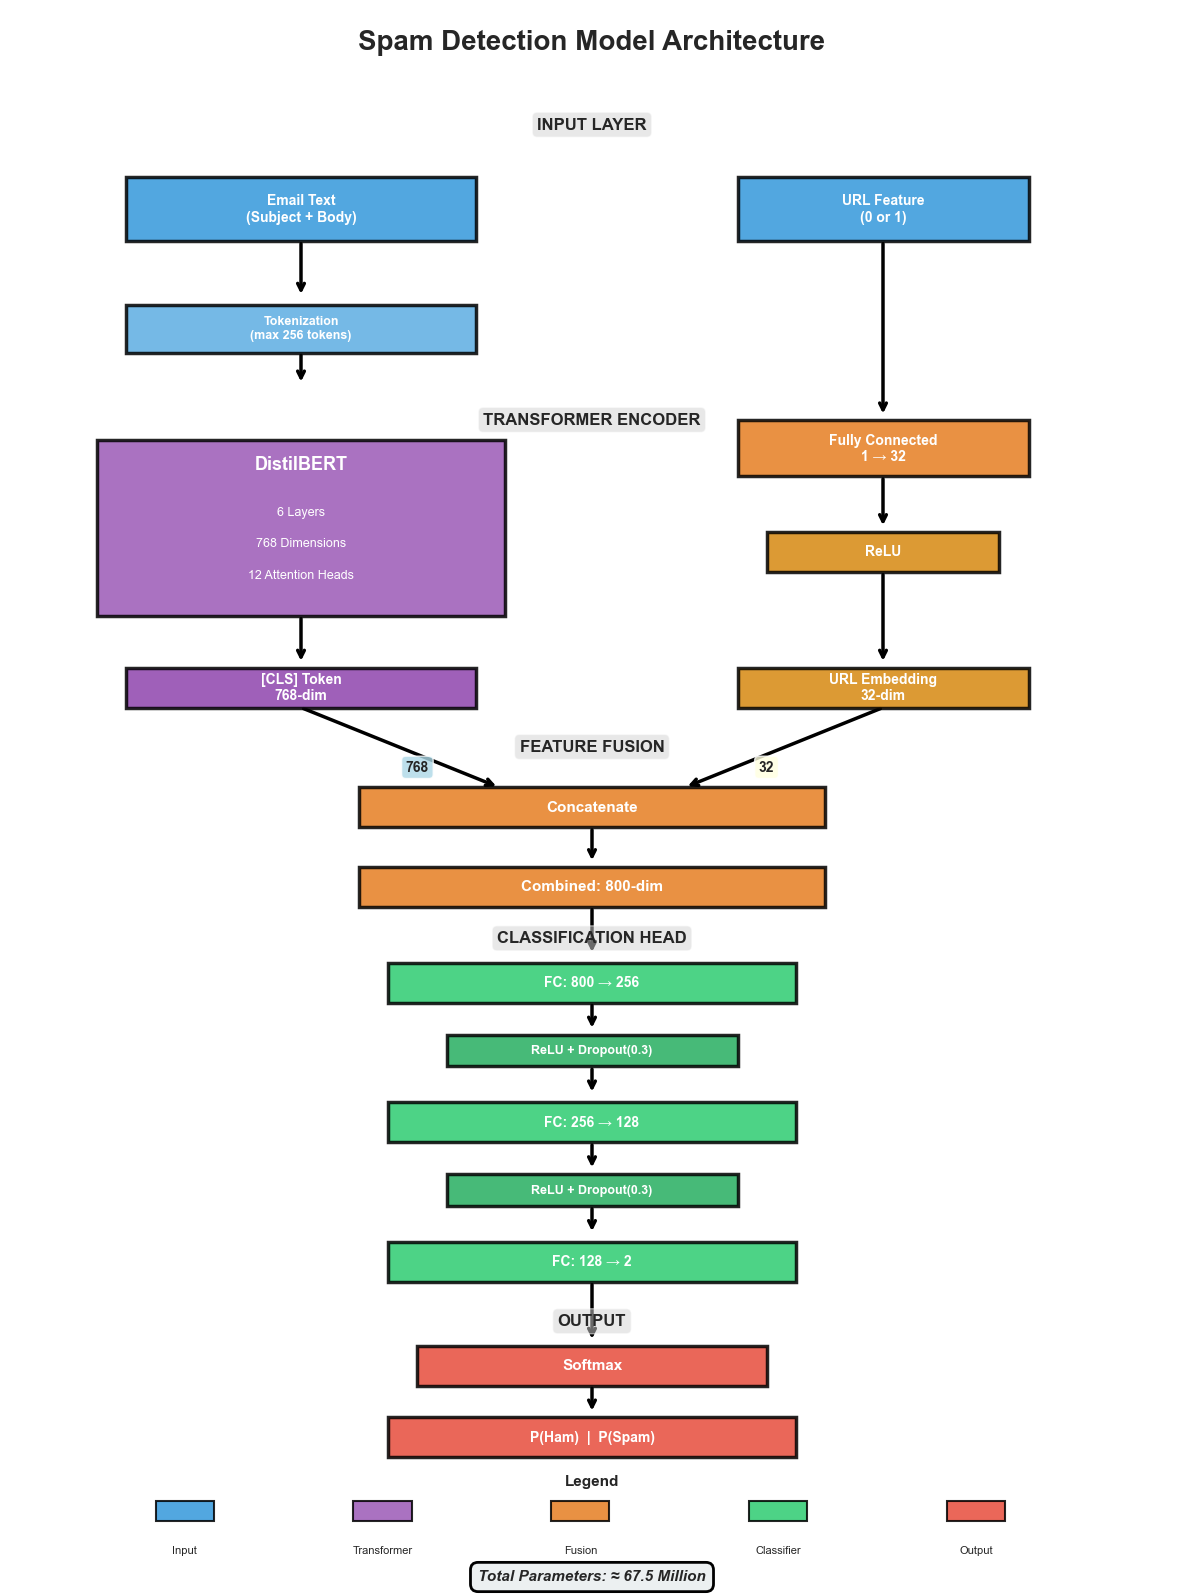

In [4]:
def plot_model_architecture():
    
    fig, ax = plt.subplots(figsize=(12, 16))
    ax.set_xlim(0, 10)
    ax.set_ylim(-5, 14)
    ax.axis('off')
    
    input_color = '#3498db'
    transformer_color = '#9b59b6'
    fusion_color = '#e67e22'
    classifier_color = '#2ecc71'
    output_color = '#e74c3c'
    
    def draw_box(x, y, width, height, text, color, fontsize=11):
        rect = plt.Rectangle((x-width/2, y-height/2), width, height, 
                            linewidth=2.5, edgecolor='black', 
                            facecolor=color, alpha=0.85, zorder=2)
        ax.add_patch(rect)
        ax.text(x, y, text, ha='center', va='center',
               fontsize=fontsize, fontweight='bold', color='white', zorder=3)
    
    def draw_arrow(x1, y1, x2, y2, lw=2.5):
        ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                   arrowprops=dict(arrowstyle='->', lw=lw, color='black'), zorder=1)
    
    ax.text(5, 13.5, 'Spam Detection Model Architecture', 
           fontsize=20, fontweight='bold', ha='center')
    
    ax.text(5, 12.5, 'INPUT LAYER', fontsize=12, ha='center', fontweight='bold', 
           bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.5))
    
    draw_box(2.5, 11.5, 3, 0.8, 'Email Text\n(Subject + Body)', input_color, fontsize=10)
    draw_box(7.5, 11.5, 2.5, 0.8, 'URL Feature\n(0 or 1)', input_color, fontsize=10)
    
    draw_arrow(2.5, 11.1, 2.5, 10.4)
    draw_box(2.5, 10, 3, 0.6, 'Tokenization\n(max 256 tokens)', '#5dade2', fontsize=9)
    
    draw_arrow(7.5, 11.1, 7.5, 8.9)
    
    draw_arrow(2.5, 9.7, 2.5, 9.3)
    
    ax.text(5, 8.8, 'TRANSFORMER ENCODER', fontsize=12, ha='center', fontweight='bold',
           bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.5))
    
    draw_box(2.5, 7.5, 3.5, 2.2, '', transformer_color, fontsize=10)
    ax.text(2.5, 8.3, 'DistilBERT', ha='center', va='center',
           fontsize=13, fontweight='bold', color='white', zorder=3)
    
    specs = ['6 Layers', '768 Dimensions', '12 Attention Heads']
    for i, spec in enumerate(specs):
        ax.text(2.5, 7.7 - i*0.4, spec, ha='center', va='center',
               fontsize=9, color='white', zorder=3)
    
    draw_arrow(2.5, 6.4, 2.5, 5.8)
    draw_box(2.5, 5.5, 3, 0.5, '[CLS] Token\n768-dim', '#8e44ad', fontsize=10)
    
    draw_box(7.5, 8.5, 2.5, 0.7, 'Fully Connected\n1 → 32', fusion_color, fontsize=10)
    draw_arrow(7.5, 8.15, 7.5, 7.5)
    draw_box(7.5, 7.2, 2, 0.5, 'ReLU', '#d68910', fontsize=10)
    draw_arrow(7.5, 6.95, 7.5, 5.8)
    draw_box(7.5, 5.5, 2.5, 0.5, 'URL Embedding\n32-dim', '#d68910', fontsize=10)
    
    ax.text(5, 4.7, 'FEATURE FUSION', fontsize=12, ha='center', fontweight='bold',
           bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.5))
    
    draw_arrow(2.5, 5.25, 4.2, 4.25)
    draw_arrow(7.5, 5.25, 5.8, 4.25)
    
    draw_box(5, 4, 4, 0.5, 'Concatenate', fusion_color, fontsize=11)
    
    ax.text(3.5, 4.5, '768', ha='center', va='center', fontsize=10, fontweight='bold',
           bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.8))
    ax.text(6.5, 4.5, '32', ha='center', va='center', fontsize=10, fontweight='bold',
           bbox=dict(boxstyle='round,pad=0.3', facecolor='lightyellow', alpha=0.8))
    
    draw_arrow(5, 3.75, 5, 3.3)
    draw_box(5, 3, 4, 0.5, 'Combined: 800-dim', fusion_color, fontsize=11)
    
    ax.text(5, 2.3, 'CLASSIFICATION HEAD', fontsize=12, ha='center', fontweight='bold',
           bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.5))
    
    draw_arrow(5, 2.75, 5, 2.15)
    
    draw_box(5, 1.8, 3.5, 0.5, 'FC: 800 → 256', classifier_color, fontsize=10)
    draw_arrow(5, 1.55, 5, 1.2)
    draw_box(5, 0.95, 2.5, 0.4, 'ReLU + Dropout(0.3)', '#27ae60', fontsize=9)
    
    draw_arrow(5, 0.75, 5, 0.4)
    
    draw_box(5, 0.05, 3.5, 0.5, 'FC: 256 → 128', classifier_color, fontsize=10)
    draw_arrow(5, -0.2, 5, -0.55)
    draw_box(5, -0.8, 2.5, 0.4, 'ReLU + Dropout(0.3)', '#27ae60', fontsize=9)
    
    draw_arrow(5, -1, 5, -1.35)
    
    draw_box(5, -1.7, 3.5, 0.5, 'FC: 128 → 2', classifier_color, fontsize=10)
    
    ax.text(5, -2.5, 'OUTPUT', fontsize=12, ha='center', fontweight='bold',
           bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.5))
    
    draw_arrow(5, -1.95, 5, -2.7)
    draw_box(5, -3, 3, 0.5, 'Softmax', output_color, fontsize=11)
    
    draw_arrow(5, -3.25, 5, -3.6)
    draw_box(5, -3.9, 3.5, 0.5, 'P(Ham)  |  P(Spam)', output_color, fontsize=10)
    
    ax.text(5, -4.5, 'Legend', fontsize=11, fontweight='bold', ha='center')
    
    legend_items = [
        (input_color, 'Input'),
        (transformer_color, 'Transformer'),
        (fusion_color, 'Fusion'),
        (classifier_color, 'Classifier'),
        (output_color, 'Output')
    ]
    
    start_x = 1.5
    spacing = 1.7
    for i, (color, label) in enumerate(legend_items):
        x_pos = start_x + i * spacing
        rect = plt.Rectangle((x_pos-0.25, -4.95), 0.5, 0.25, 
                            facecolor=color, edgecolor='black', linewidth=1.5, alpha=0.85)
        ax.add_patch(rect)
        ax.text(x_pos, -5.25, label, ha='center', va='top', fontsize=8)

    ax.text(5, -5.7, 'Total Parameters: ≈ 67.5 Million', 
           fontsize=11, ha='center', style='italic', fontweight='bold',
           bbox=dict(boxstyle='round,pad=0.5', facecolor='#ecf0f1', edgecolor='black', linewidth=2))
    
    plt.tight_layout()
    plt.savefig('model_architecture.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

plot_model_architecture()

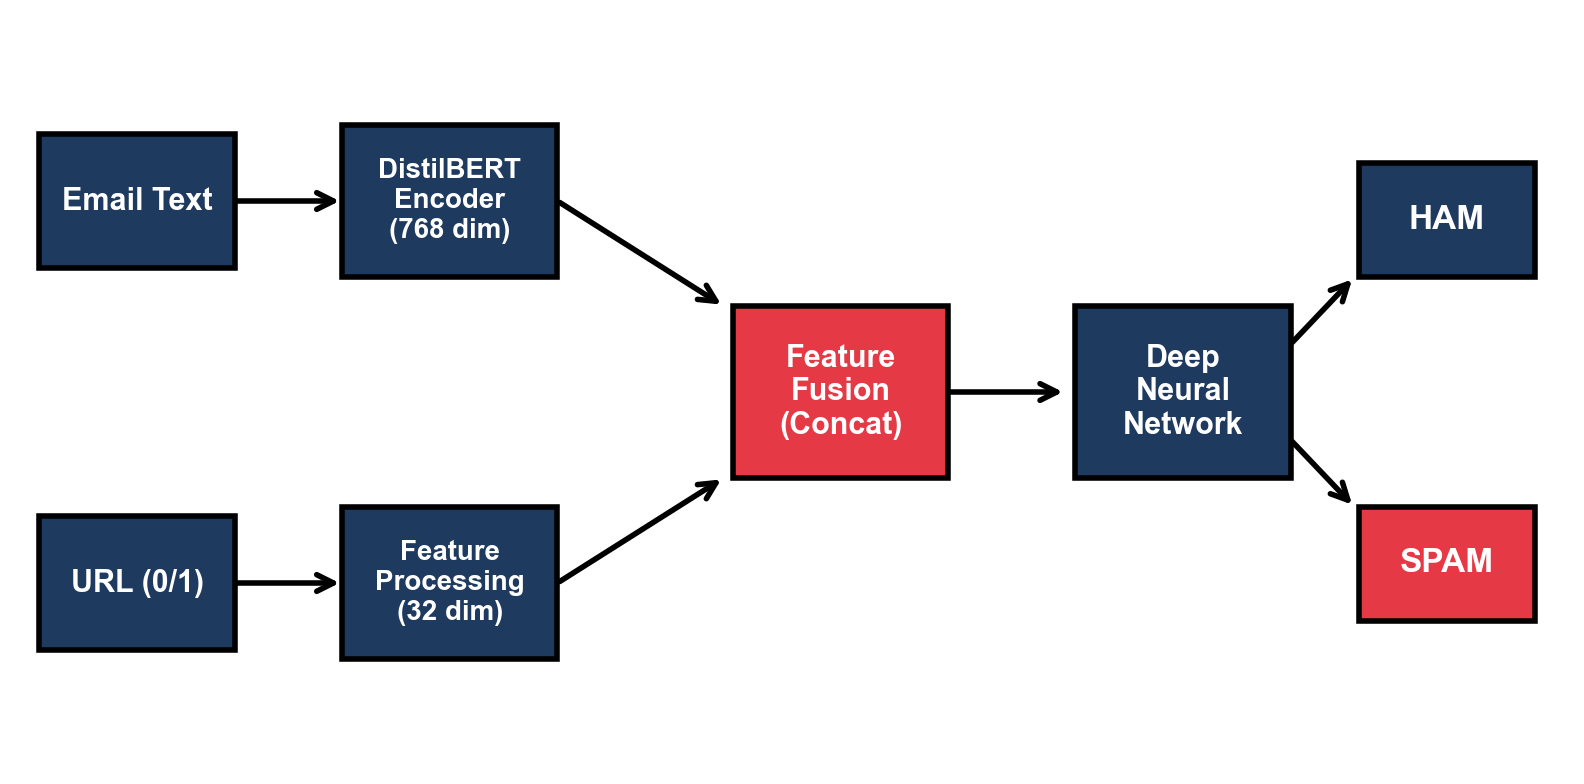

In [5]:
# Simplified model architecture

def plot_simple_architecture():
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.set_xlim(0, 16)
    ax.set_ylim(0, 8)
    ax.axis('off')
    
    primary_color = '#1e3a5f'
    accent_color = '#e63946'
    
    def draw_box(x, y, width, height, text, color, fontsize=20):
        rect = plt.Rectangle((x-width/2, y-height/2), width, height,
                             linewidth=4, edgecolor='black',
                             facecolor=color, alpha=1, zorder=2)
        ax.add_patch(rect)
        ax.text(x, y, text, ha='center', va='center',
                fontsize=fontsize, fontweight='bold', color='white', zorder=3)
    
    def draw_arrow(x1, y1, x2, y2, lw=4):
        ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                    arrowprops=dict(arrowstyle='->', lw=lw, color='black',
                                    mutation_scale=30), zorder=1)
    
    draw_box(1.3, 6, 2, 1.4, 'Email Text', primary_color, fontsize=22)
    draw_box(1.3, 2, 2, 1.4, 'URL (0/1)', primary_color, fontsize=22)
    
    draw_arrow(2.3, 6, 3.4, 6)
    draw_arrow(2.3, 2, 3.4, 2)
    
    draw_box(4.5, 6, 2.2, 1.6, 'DistilBERT\nEncoder\n(768 dim)', primary_color, fontsize=20)
    draw_box(4.5, 2, 2.2, 1.6, 'Feature\nProcessing\n(32 dim)', primary_color, fontsize=20)
    
    draw_arrow(5.6, 6, 7.3, 4.9)
    draw_arrow(5.6, 2, 7.3, 3.1)
    
    draw_box(8.5, 4, 2.2, 1.8, 'Feature\nFusion\n(Concat)', accent_color, fontsize=22)
    
    draw_arrow(9.6, 4, 10.8, 4)
    
    draw_box(12, 4, 2.2, 1.8, 'Deep\nNeural\nNetwork', primary_color, fontsize=22)
    
    draw_arrow(13.1, 4.5, 13.75, 5.2)
    draw_arrow(13.1, 3.5, 13.75, 2.8)

    draw_box(14.7, 5.8, 1.8, 1.2, 'HAM', primary_color, fontsize=24)
    draw_box(14.7, 2.2, 1.8, 1.2, 'SPAM', accent_color, fontsize=24)
    
    plt.tight_layout()
    plt.savefig('model_architecture_simple.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

plot_simple_architecture()

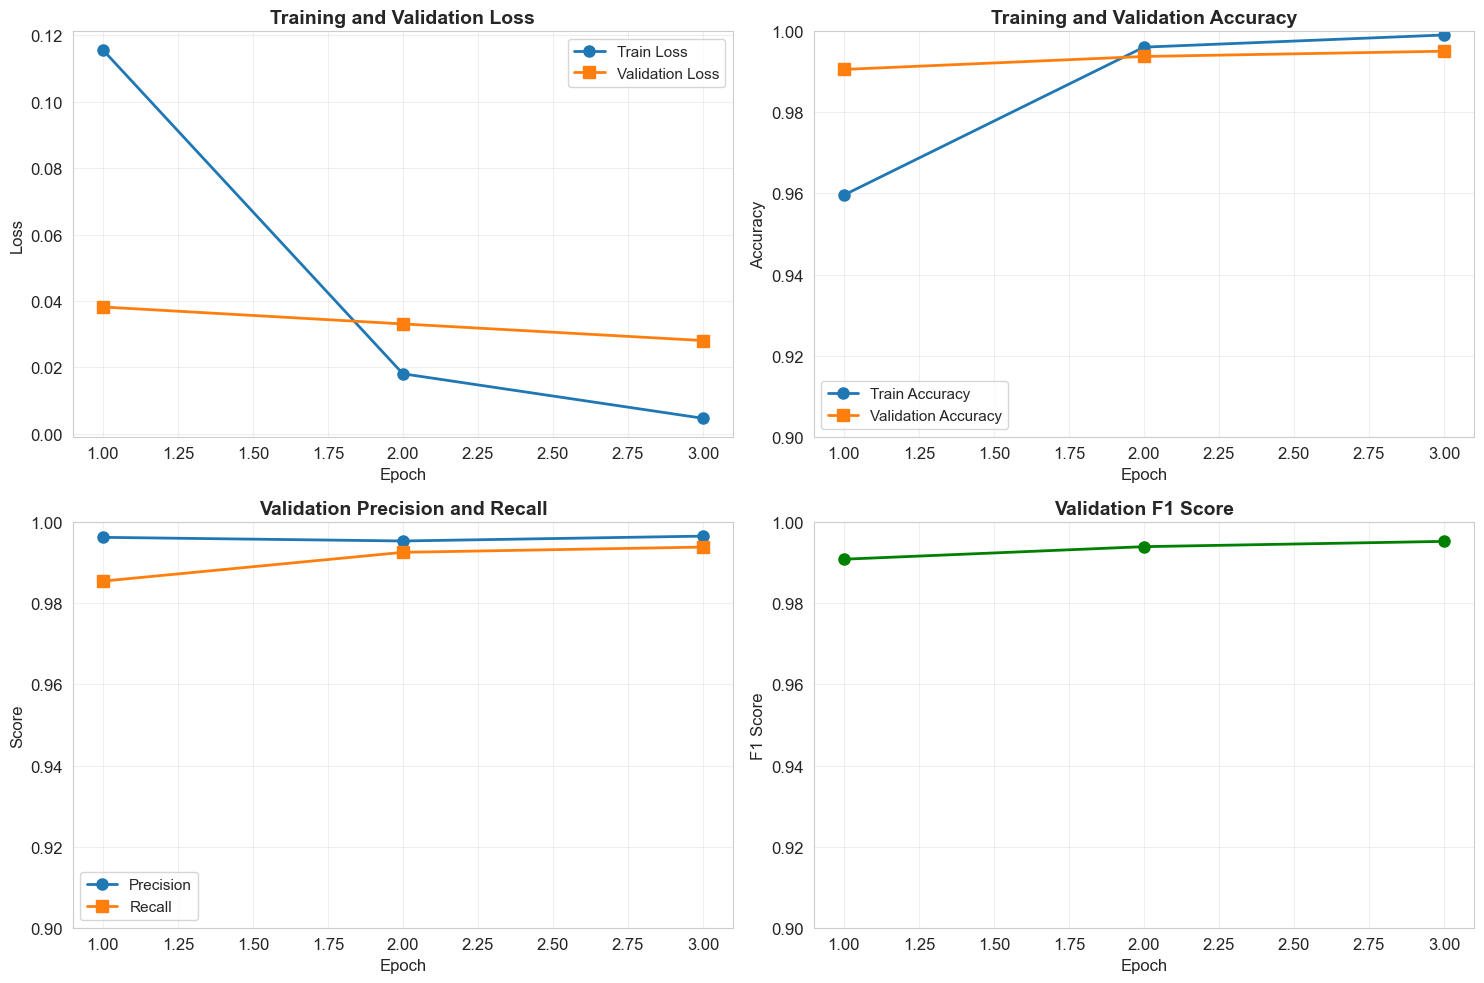

In [6]:
# Training history

training_history = {
    'epochs': [1, 2, 3],
    'train_loss': [0.1156, 0.0181, 0.0047],
    'val_loss': [0.0382, 0.0331, 0.0281],
    'train_acc': [0.9596, 0.9961, 0.9991],
    'val_acc': [0.9906, 0.9938, 0.9951],
    'val_precision': [0.9963, 0.9954, 0.9966],
    'val_recall': [0.9855, 0.9926, 0.9939],
    'val_f1': [0.9909, 0.9940, 0.9953]
}

def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    axes[0, 0].plot(history['epochs'], history['train_loss'], 'o-', label='Train Loss', linewidth=2, markersize=8)
    axes[0, 0].plot(history['epochs'], history['val_loss'], 's-', label='Validation Loss', linewidth=2, markersize=8)
    axes[0, 0].set_xlabel('Epoch', fontsize=12)
    axes[0, 0].set_ylabel('Loss', fontsize=12)
    axes[0, 0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0, 0].legend(fontsize=11)
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].plot(history['epochs'], history['train_acc'], 'o-', label='Train Accuracy', linewidth=2, markersize=8)
    axes[0, 1].plot(history['epochs'], history['val_acc'], 's-', label='Validation Accuracy', linewidth=2, markersize=8)
    axes[0, 1].set_xlabel('Epoch', fontsize=12)
    axes[0, 1].set_ylabel('Accuracy', fontsize=12)
    axes[0, 1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    axes[0, 1].legend(fontsize=11)
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_ylim([0.9, 1.0])

    axes[1, 0].plot(history['epochs'], history['val_precision'], 'o-', label='Precision', linewidth=2, markersize=8)
    axes[1, 0].plot(history['epochs'], history['val_recall'], 's-', label='Recall', linewidth=2, markersize=8)
    axes[1, 0].set_xlabel('Epoch', fontsize=12)
    axes[1, 0].set_ylabel('Score', fontsize=12)
    axes[1, 0].set_title('Validation Precision and Recall', fontsize=14, fontweight='bold')
    axes[1, 0].legend(fontsize=11)
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_ylim([0.9, 1.0])

    axes[1, 1].plot(history['epochs'], history['val_f1'], 'o-', color='green', linewidth=2, markersize=8)
    axes[1, 1].set_xlabel('Epoch', fontsize=12)
    axes[1, 1].set_ylabel('F1 Score', fontsize=12)
    axes[1, 1].set_title('Validation F1 Score', fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_ylim([0.9, 1.0])
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_training_history(training_history)

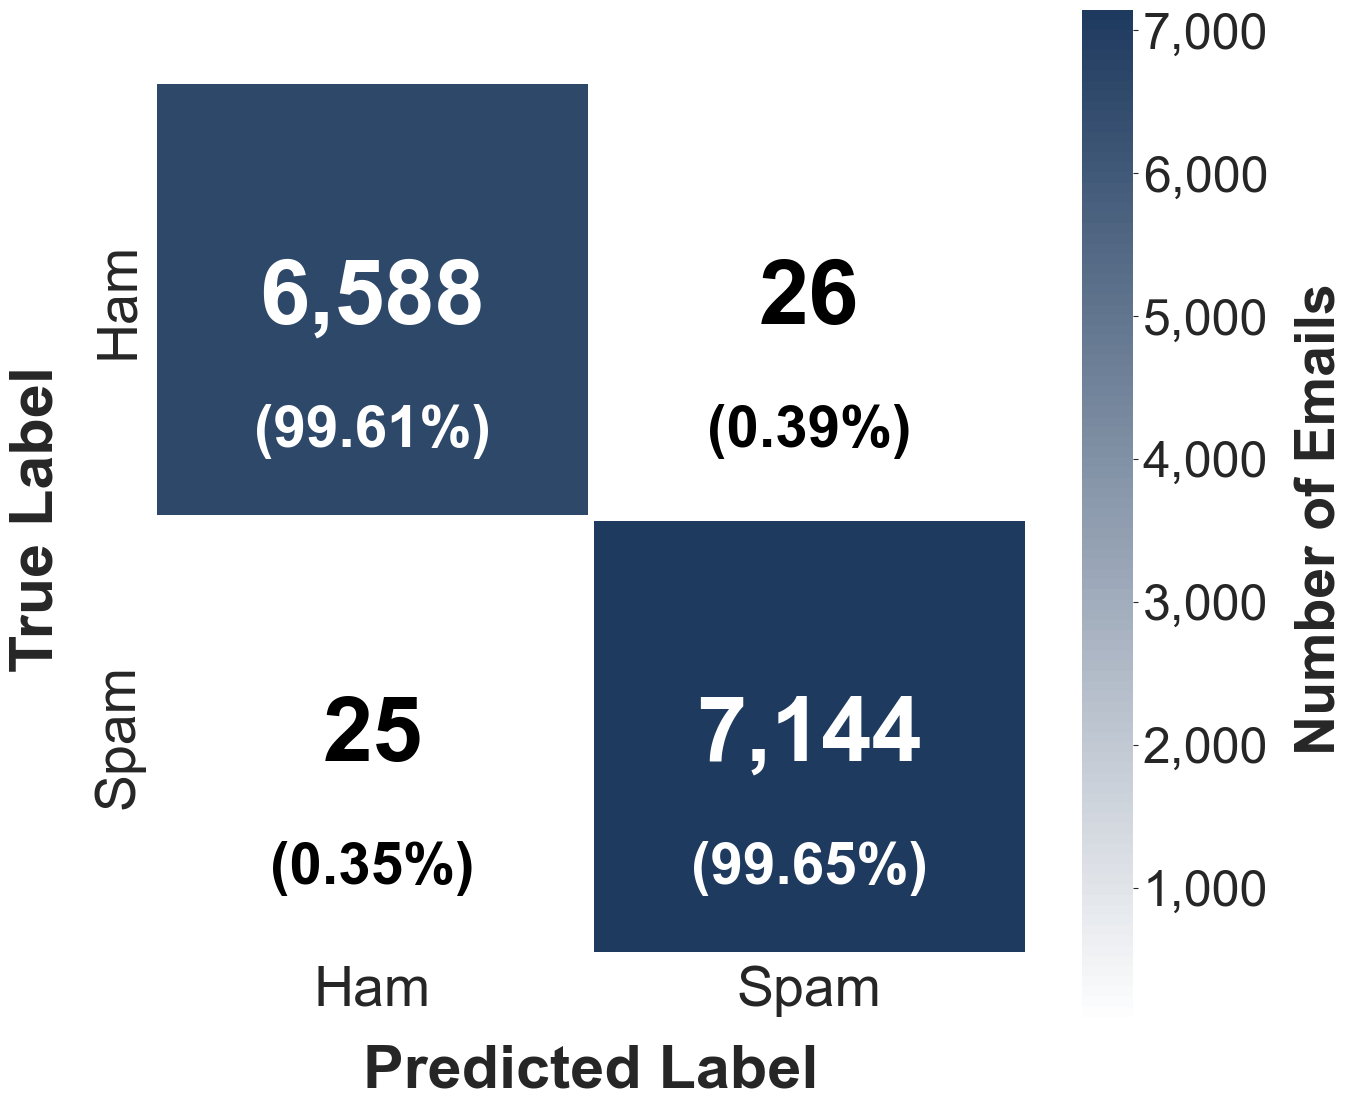

True Negatives (Correctly identified Ham): 6,588
False Positives (Ham marked as Spam): 26
False Negatives (Spam marked as Ham): 25
True Positives (Correctly identified Spam): 7,144


In [16]:
# Confusion Matrix

test_cm = np.array([[6588, 26], 
                     [25, 7144]])

def plot_confusion_matrix(cm=None, true_labels=None, predictions=None, class_names=['Ham', 'Spam']):

    if cm is None:
        cm = confusion_matrix(true_labels, predictions)
    
    fig, ax = plt.subplots(figsize=(14, 12))
    
    from matplotlib.colors import LinearSegmentedColormap
    colors = ['#ffffff', '#1e3a5f']
    n_bins = 100
    cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)
    
    # Format annotations with commas
    cm_formatted = [[f'{value:,}' for value in row] for row in cm]
    
    sns.heatmap(cm, annot=cm_formatted, fmt='', cmap=cmap, 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Number of Emails'},
                annot_kws={'size': 65, 'weight': 'bold'},
                ax=ax,
                linewidths=3,
                linecolor='white',
                square=True)
    
    cbar = ax.collections[0].colorbar
    cbar.set_label('Number of Emails', size=40, weight='bold', labelpad=20)
    cbar.ax.tick_params(labelsize=36)
    
    # Format colorbar ticks with commas
    cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
    
    ax.set_xlabel('Predicted Label', fontsize=44, fontweight='bold', labelpad=20)
    ax.set_ylabel('True Label', fontsize=44, fontweight='bold', labelpad=20)
    ax.tick_params(axis='both', labelsize=40)
    
    texts = ax.texts
    texts[0].set_color('white')  # Top-left (TN)
    texts[1].set_color('black')  # Top-right (FP)
    texts[2].set_color('black')  # Bottom-left (FN)
    texts[3].set_color('white')  # Bottom-right (TP)
    
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            percent_color = 'white' if i == j else 'black'
            ax.text(j + 0.5, i + 0.8, f'({cm_percent[i, j]:.2f}%)', 
                   ha='center', va='center', fontsize=42, color=percent_color, weight='bold')
    
    plt.tight_layout(pad=2.0)
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"True Negatives (Correctly identified Ham): {cm[0, 0]:,}")
    print(f"False Positives (Ham marked as Spam): {cm[0, 1]:,}")
    print(f"False Negatives (Spam marked as Ham): {cm[1, 0]:,}")
    print(f"True Positives (Correctly identified Spam): {cm[1, 1]:,}")

plot_confusion_matrix(cm=test_cm)

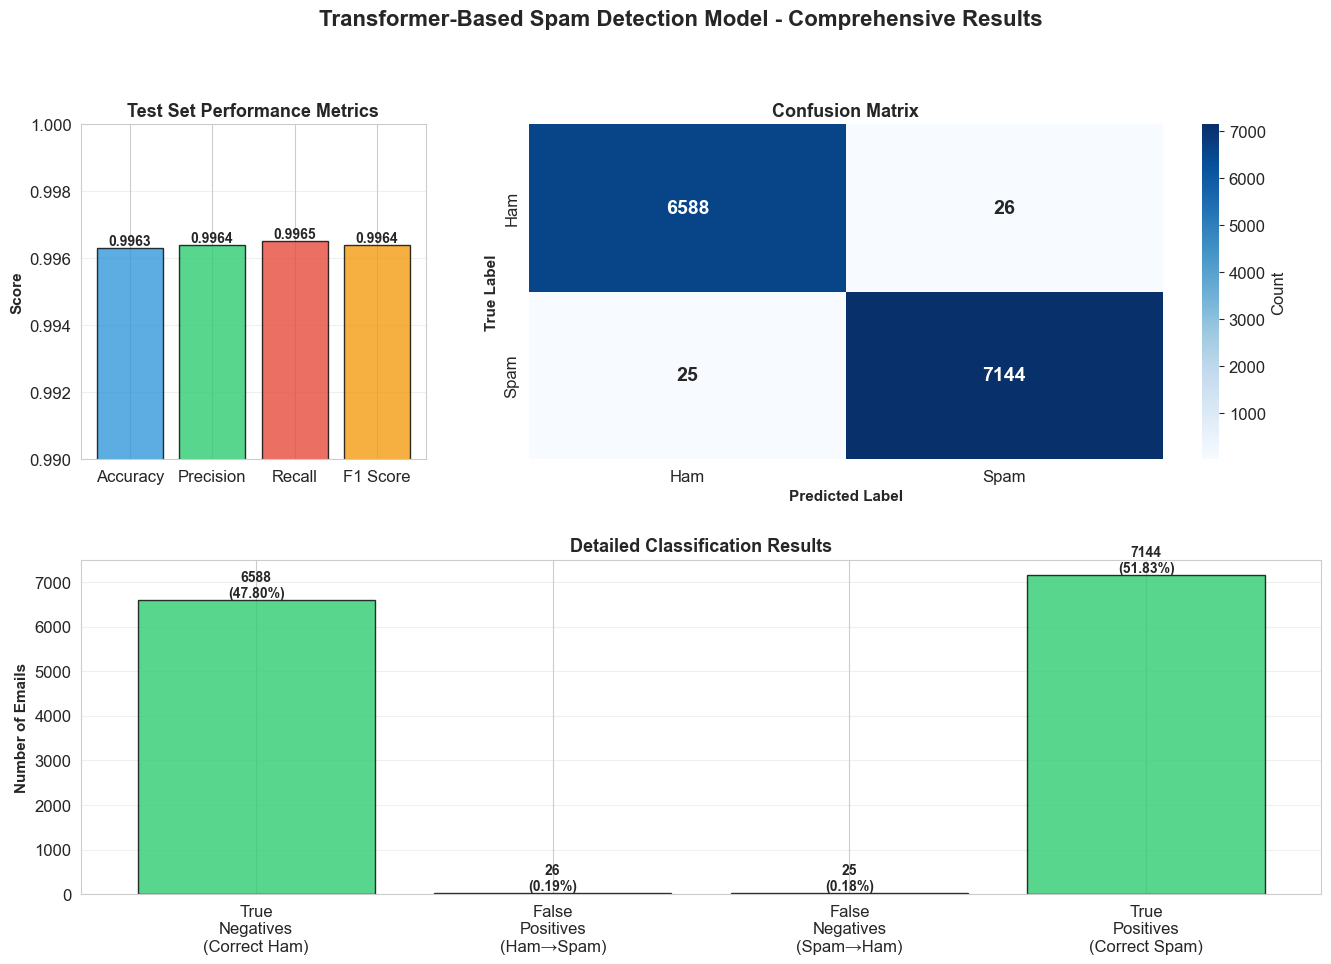

In [8]:
# Overview

test_metrics = {
    'accuracy': 0.9963,
    'precision': 0.9964,
    'recall': 0.9965,
    'f1': 0.9964
}

test_cm = np.array([[6588, 26], 
                     [25, 7144]])

def plot_comprehensive_results(test_metrics, cm):

    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

    ax1 = fig.add_subplot(gs[0, 0])
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    values = [test_metrics['accuracy'], test_metrics['precision'], 
              test_metrics['recall'], test_metrics['f1']]
    colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']
    bars = ax1.bar(metrics, values, color=colors, alpha=0.8, edgecolor='black')
    ax1.set_ylabel('Score', fontsize=11, fontweight='bold')
    ax1.set_title('Test Set Performance Metrics', fontsize=13, fontweight='bold')
    ax1.set_ylim([0.99, 1.0])
    ax1.grid(True, alpha=0.3, axis='y')
    for bar, val in zip(bars, values):
        ax1.text(bar.get_x() + bar.get_width()/2, val, f'{val:.4f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

    ax2 = fig.add_subplot(gs[0, 1:])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'],
                cbar_kws={'label': 'Count'}, annot_kws={'size': 14, 'weight': 'bold'},
                ax=ax2)
    ax2.set_xlabel('Predicted Label', fontsize=11, fontweight='bold')
    ax2.set_ylabel('True Label', fontsize=11, fontweight='bold')
    ax2.set_title('Confusion Matrix', fontsize=13, fontweight='bold')
    
    ax3 = fig.add_subplot(gs[1, :])
    categories = ['True\nNegatives\n(Correct Ham)', 
                  'False\nPositives\n(Ham→Spam)', 
                  'False\nNegatives\n(Spam→Ham)', 
                  'True\nPositives\n(Correct Spam)']
    counts = [cm[0,0], cm[0,1], cm[1,0], cm[1,1]]
    colors_error = ['#2ecc71', '#e74c3c', '#e74c3c', '#2ecc71']
    bars = ax3.bar(categories, counts, color=colors_error, alpha=0.8, edgecolor='black')
    ax3.set_ylabel('Number of Emails', fontsize=11, fontweight='bold')
    ax3.set_title('Detailed Classification Results', fontsize=13, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')

    total = sum(counts)
    for bar, count in zip(bars, counts):
        percentage = (count / total) * 100
        ax3.text(bar.get_x() + bar.get_width()/2, count,
                f'{count}\n({percentage:.2f}%)',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.suptitle('Transformer-Based Spam Detection Model - Comprehensive Results', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    plt.savefig('comprehensive_results.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_comprehensive_results(test_metrics, test_cm)

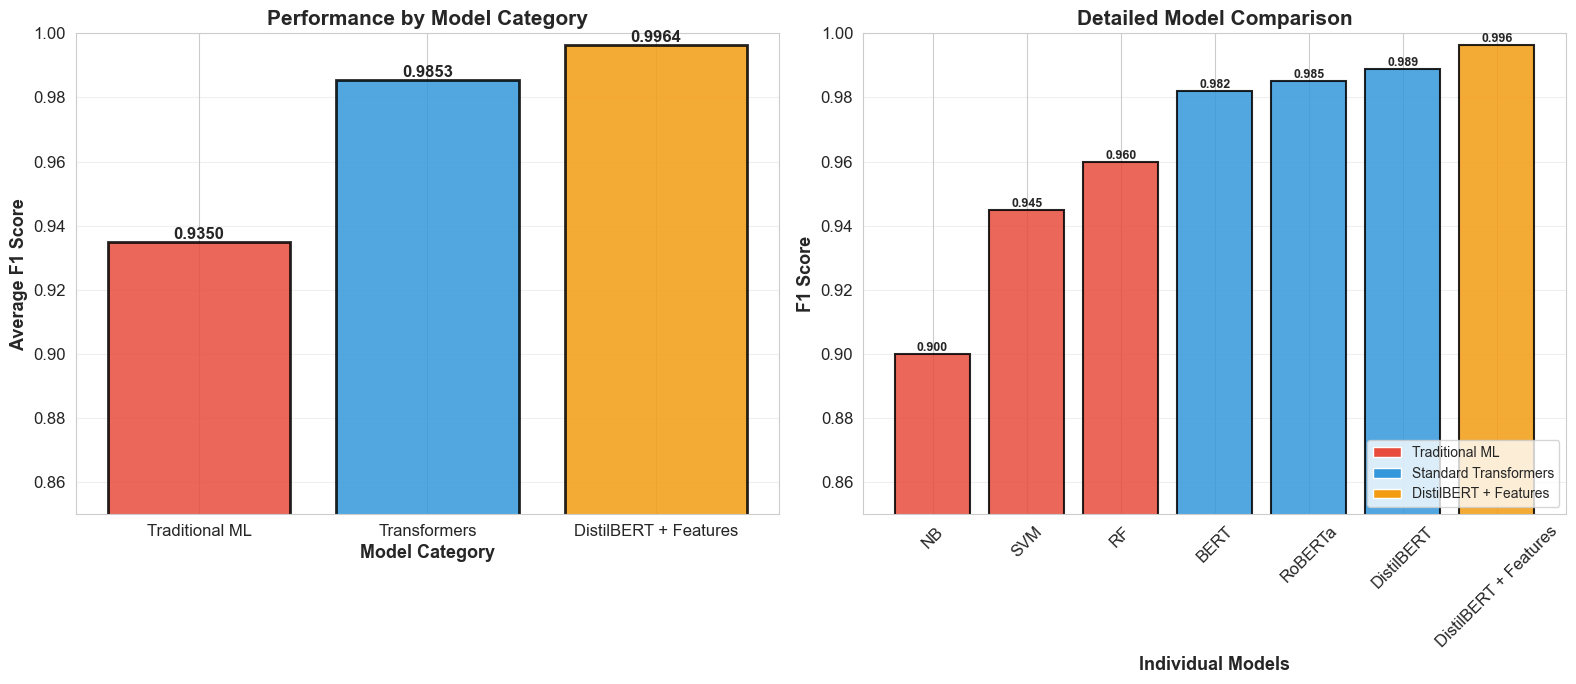

In [9]:
# Compare traditional ML, standard transformers, and your enhanced model

def plot_comprehensive_model_comparison():

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

    categories = ['Traditional ML', 'Transformers', 'DistilBERT + Features']
    models_per_cat = [
        ['Naive Bayes', 'SVM', 'Random Forest'],
        ['BERT', 'RoBERTa', 'DistilBERT'],
        ['DistilBERT\n+ Features']
    ]
    f1_per_cat = [
        [0.90, 0.945, 0.96],
        [0.982, 0.985, 0.989],
        [0.9964]
    ]
    colors_cat = ['#e74c3c', '#3498db', '#f39c12']

    avg_f1 = [np.mean(scores) for scores in f1_per_cat]
    
    bars = ax1.bar(categories, avg_f1, color=colors_cat, alpha=0.85, edgecolor='black', linewidth=2)
    ax1.set_ylabel('Average F1 Score', fontsize=13, fontweight='bold')
    ax1.set_xlabel('Model Category', fontsize=13, fontweight='bold')
    ax1.set_title('Performance by Model Category', fontsize=15, fontweight='bold')
    ax1.set_ylim([0.85, 1.0])
    ax1.grid(True, alpha=0.3, axis='y')
    
    for bar, score in zip(bars, avg_f1):
        ax1.text(bar.get_x() + bar.get_width()/2., score,
                f'{score:.4f}', ha='center', va='bottom', 
                fontsize=12, fontweight='bold')

    all_models = ['NB', 'SVM', 'RF', 'BERT', 'RoBERTa', 'DistilBERT', 'DistilBERT + Features']
    all_scores = [0.90, 0.945, 0.96, 0.982, 0.985, 0.989, 0.9964]
    all_colors = ['#e74c3c']*3 + ['#3498db']*3 + ['#f39c12']
    
    bars2 = ax2.bar(all_models, all_scores, color=all_colors, alpha=0.85, edgecolor='black', linewidth=1.5)
    ax2.set_ylabel('F1 Score', fontsize=13, fontweight='bold')
    ax2.set_xlabel('Individual Models', fontsize=13, fontweight='bold')
    ax2.set_title('Detailed Model Comparison', fontsize=15, fontweight='bold')
    ax2.set_ylim([0.85, 1.0])
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.tick_params(axis='x', rotation=45)
    
    for bar, score in zip(bars2, all_scores):
        ax2.text(bar.get_x() + bar.get_width()/2., score,
                f'{score:.3f}', ha='center', va='bottom', 
                fontsize=9, fontweight='bold', rotation=0)

    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#e74c3c', label='Traditional ML'),
        Patch(facecolor='#3498db', label='Standard Transformers'),
        Patch(facecolor='#f39c12', label='DistilBERT + Features')
    ]
    ax2.legend(handles=legend_elements, loc='lower right', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('comprehensive_model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_comprehensive_model_comparison()


In [10]:
def calculate_url_statistics(df):

    spam_emails = df[df['label'] == 1]
    ham_emails = df[df['label'] == 0]
    
    spam_with_url_pct = (spam_emails['urls'].sum() / len(spam_emails)) * 100
    ham_with_url_pct = (ham_emails['urls'].sum() / len(ham_emails)) * 100
    
    print("="*60)
    print("URL FEATURE STATISTICS")
    print("="*60)
    print(f"\nSpam Emails:")
    print(f"  Total: {len(spam_emails):,}")
    print(f"  With URLs: {spam_emails['urls'].sum():,}")
    print(f"  Percentage with URLs: {spam_with_url_pct:.2f}%")
    
    print(f"\nLegitimate (Ham) Emails:")
    print(f"  Total: {len(ham_emails):,}")
    print(f"  With URLs: {ham_emails['urls'].sum():,}")
    print(f"  Percentage with URLs: {ham_with_url_pct:.2f}%")
    
    print(f"\nDifference: {spam_with_url_pct - ham_with_url_pct:.2f} percentage points")
    print("="*60)
    
    return {
        'spam_with_url_pct': spam_with_url_pct,
        'ham_with_url_pct': ham_with_url_pct,
        'spam_total': len(spam_emails),
        'ham_total': len(ham_emails),
        'spam_with_url_count': spam_emails['urls'].sum(),
        'ham_with_url_count': ham_emails['urls'].sum()
    }

result = calculate_url_statistics(df)

URL FEATURE STATISTICS

Spam Emails:
  Total: 47,788
  With URLs: 36,005
  Percentage with URLs: 75.34%

Legitimate (Ham) Emails:
  Total: 44,094
  With URLs: 35,280
  Percentage with URLs: 80.01%

Difference: -4.67 percentage points
